In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [3]:
print(tf.__version__)


2.19.0


In [4]:
os.listdir(os.getcwd())

['imdbEr.txt',
 '.ipynb_checkpoints',
 'imdb.vocab',
 'README',
 'practice.ipynb',
 'test',
 'train']

In [5]:
train_dir = os.path.join(os.getcwd(), 'train')
os.listdir(train_dir)


['pos',
 'neg',
 'unsupBow.feat',
 'urls_pos.txt',
 'urls_unsup.txt',
 'labeledBow.feat',
 'urls_neg.txt']

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())


Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
remove_dir = os.path.join(train_dir, 'unsup')

if os.path.exists(remove_dir):
    print(f"Found directory, removing: {remove_dir}")
    shutil.rmtree(remove_dir)
else:
    print(f"Directory already removed: {remove_dir}")

Directory already removed: /home/tanvir/Desktop/Deep Learning/Text Classification/aclImdb/train/unsup


In [8]:
batch_size = 32
seed = 42
data_path = r'/home/tanvir/Desktop/Deep Learning/Text Classification'

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    data_path,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 50006 files belonging to 1 classes.
Using 40005 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])


Review b"**Spoilers contained**<br /><br />I'd heard from various sources that this film was controversial and that the ending in particular was horrific. What I didn't expect was the complete change in tack with about twenty minutes to go. What starts off as a typical cowboy/indian western suddenly descends into a very dull romantic 'comedy' about Honus (Soldier Blue of the title played by Peter Strauss) and Cresta (Candice Bergen) who escape an onslaught of the cavalry by the Cheyenne. The majority of the film then focuses on these two mismatched people hence the romantic comedy bit. Donald Pleasance then turns up and abducts them both for no real apparent reason. They then escape and both turn up (separately) at the cavalry base on the eve of an attack on the Cheyenne base. As Cresta used to be married to one of the Cheyenne chiefs she escapes the cavalry base and joins up with them. So far so ordinary. Then comes the ending. After enduring well over an hour of poor acting involving

2025-11-12 21:27:53.768319: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test',
    batch_size=batch_size)


Found 25000 files belonging to 2 classes.


In [12]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')


In [13]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


In [14]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)


2025-11-12 21:29:44.107555: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


In [16]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))


Review tf.Tensor(b'I want to preface this review by saying that I have no idea what "Begotten" is truly about. All I really know is that in the beginning God kills himself, in turn birthing Mother Earth, who proceeds to impregnate herself with God\'s semen. She then births a son. The rest is pretty subjective, and you have to interpret it in your own way.<br /><br />How I chose to interpret the film was this; God killing himself signified the start of the scientific revolution, when people started questioning the doctrines imposed by the church, like the geocentric view of the universe and etc. Mother Earth symbolized people starting to think for themselves and reject the church\'s "it happens like this because God says so" views. The Tribal people were the church lashing back at them, trying to force Christianity down their throats. I\'m not exactly sure how Son Of Earth fits into all of this. Mother Earth and the Tribal people seemed to be fighting over him, so maybe he represents th

In [18]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))


1287 --->  sam
 313 --->  excellent
Vocabulary size: 10000


In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [22]:
embedding_dim = 16


In [23]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])


In [37]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)


Epoch 1/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - binary_accuracy: 0.9995 - loss: 0.1824 - val_binary_accuracy: 0.4924 - val_loss: 3302.7625
Epoch 2/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - binary_accuracy: 1.0000 - loss: 1.5116e-08 - val_binary_accuracy: 0.4924 - val_loss: 3454.7595
Epoch 3/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - binary_accuracy: 1.0000 - loss: 1.3967e-09 - val_binary_accuracy: 0.4924 - val_loss: 3502.0449
Epoch 4/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - binary_accuracy: 1.0000 - loss: 3.3297e-09 - val_binary_accuracy: 0.4924 - val_loss: 3638.2769
Epoch 5/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - binary_accuracy: 1.0000 - loss: 2.3757e-09 - val_binary_accuracy: 0.4924 - val_loss: 3753.2568
Epoch 6/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - binary_accuracy: 1.0000 - loss: 2.1619e-09 - val_binary_accuracy: 0.4924 - val_loss: 3860.0972
Epoch 7/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - binary_accuracy: 1.0000 - loss: 3.7687e-

In [38]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.5000 - loss: 3779.3247
Loss:  3779.32470703125
Accuracy:  0.5


In [39]:
history_dict = history.history
history_dict.keys()


dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

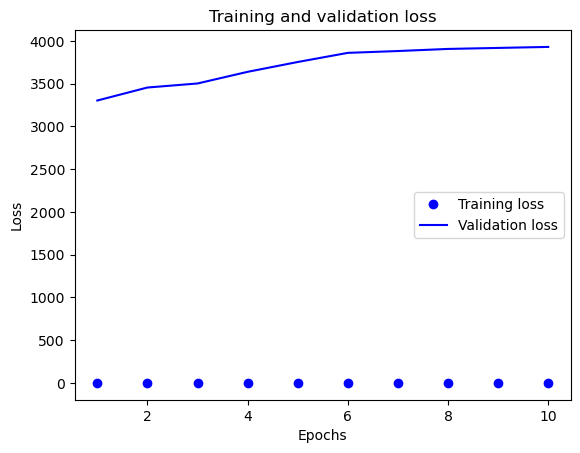

In [40]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
